In [31]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import re
%matplotlib inline
pd.set_option('display.max_columns', 100)

In [32]:
df = pd.read_csv('final_df.csv')

In [33]:
### Drop Null Values *will amend if there is time* ###
df = df.dropna(subset=['weather_temperature'])

### Drop Columns not need for EDA ###
df = df.drop(columns=['weather_humidity','weather_detail','stadium_address','stadium_weather_station_code',
                      'stadium_weather_type','STATION','ELEVATION'])
df['over_under_result'] = np.where(df['over_under_result'] == 'Over',1,0)

## Target Variable: Over/Under Result

In [34]:
### Check Class Imbalalance ###

df.over_under_result.value_counts()

0    4853
1    4553
Name: over_under_result, dtype: int64

In [37]:
### Percentages of Classes ###
print("Percent 'Under' Outcomes")
print(round((df.groupby(['over_under_result']).over_under_result.count()[0]/
       df.groupby(['over_under_result']).over_under_result.count().sum()),2))
print("Percent 'Over' Outcomes")
print(round((df.groupby(['over_under_result']).over_under_result.count()[1]/
       df.groupby(['over_under_result']).over_under_result.count().sum()),2))


Percent 'Under' Outcomes
0.52
Percent 'Over' Outcomes
0.48


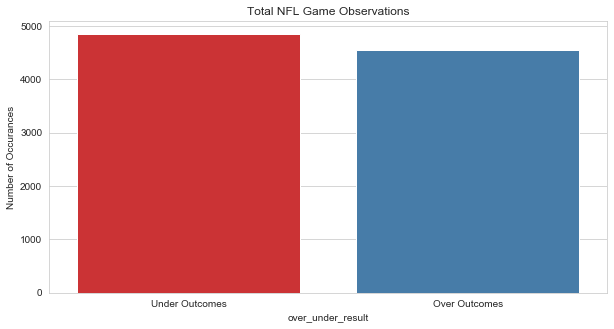

In [39]:
### Target Variable Countplot to help Visualize Class Imbalance ###

plt.figure(figsize = (10,5))
sns.countplot(df['over_under_result'], palette="Set1")
sns.set_style("whitegrid")
plt.title('Total NFL Game Observations')
plt.ylabel('Number of Occurances')
plt.xticks(np.arange(2), ['Under Outcomes','Over Outcomes'])
plt.show()

## Independent Variable 1: Season

1979 to 2020

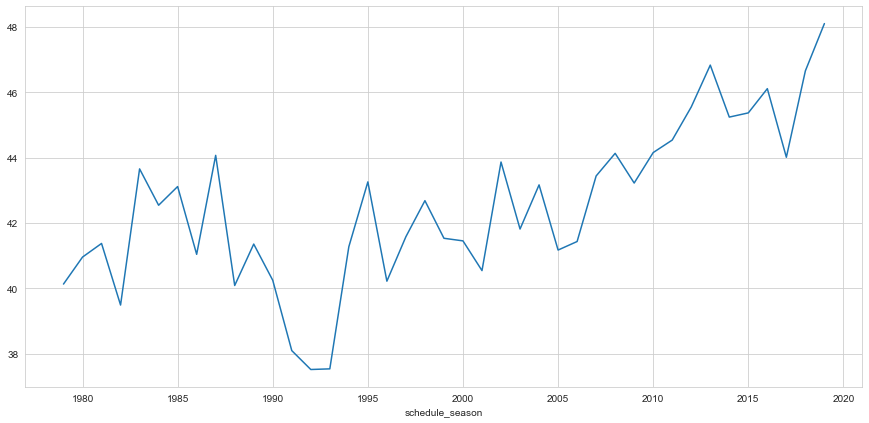

In [9]:
# Total Points seems to be slightly increasing over time

fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['schedule_season'])['total'].mean().plot(ax=ax)

## Independent Variable 2: Schedule Week

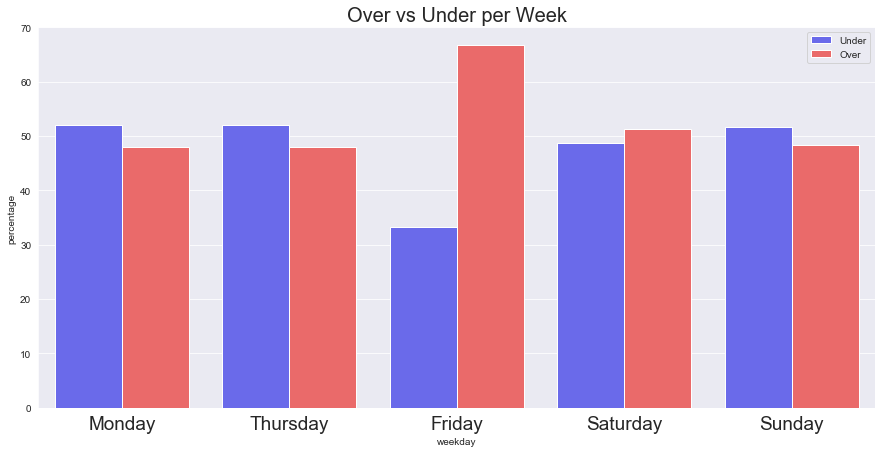

In [60]:
### Build Dataset that Groups by Week and Over Result, then get Percentage Over or Under ###
weekday_percent = (df.groupby(['weekday'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))

### Get Rid of Monday and Tuesday because not enough games are played on those day ###
weekday_percent = weekday_percent[(weekday_percent.weekday != 1) & (weekday_percent.weekday != 2)]

### Plot ###
plt.figure(figsize = (15,7))
sns.set_style("darkgrid")
weekday_bar = sns.barplot(x="weekday", y="percentage", hue="over_under_result", data=weekday_percent, palette='seismic')
weekday_bar = plt.xticks(np.arange(5), ['Monday','Thursday','Friday','Saturday','Sunday'],fontsize=19)
weekday_bar = plt.title('Over vs Under per Week',fontsize = 20)
weekday_bar = plt.legend()
weekday_bar.get_texts()[1].set_text('Over')
weekday_bar.get_texts()[0].set_text('Under')


## Independent Variable 3: Spread

In [85]:
spread_percent = (df.groupby(['spread_favorite'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))
spread_percent = spread_percent[(spread_percent.percentage < 98)]

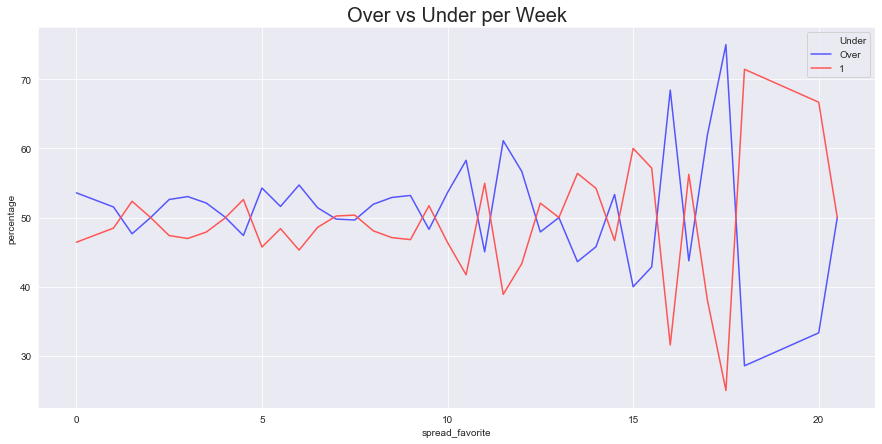

In [86]:
plt.figure(figsize = (15,7))
sns.set_style("darkgrid")
spread_line = sns.lineplot(x="spread_favorite", y="percentage", hue="over_under_result", data=spread_percent, palette='seismic')
#weekday_bar = plt.xticks(np.arange(5), ['Monday','Thursday','Friday','Saturday','Sunday'],fontsize=19)
spread_line = plt.title('Over vs Under per Week',fontsize = 20)
spread_line = plt.legend()
spread_line.get_texts()[1].set_text('Over')
spread_line.get_texts()[0].set_text('Under')


Text(0.5, 0, 'Spread')

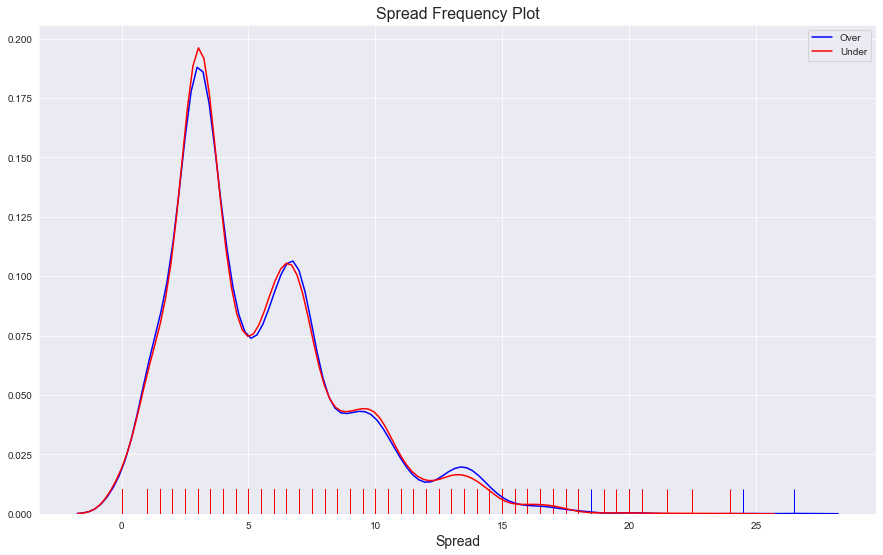

In [15]:
fig, ax = plt.subplots(figsize = (15,9));
op = sns.distplot(df[df['over_under_result']== 'Over'].spread_favorite, color='blue',hist=False, rug=True, label = 'Over')
op = sns.distplot(df[df['over_under_result']== 'Under'].spread_favorite, color='red',hist=False, rug=True, label = 'Under')
op.set_title('Spread Frequency Plot',fontsize=16)
plt.xlabel('Spread',fontsize=14)


## Independant Variable 4: Wind Mile per Hour

In [16]:
df.weather_wind_mph.describe()

count    9406.000000
mean        7.310121
std         5.715796
min         0.000000
25%         1.000000
50%         8.000000
75%        11.000000
max        40.000000
Name: weather_wind_mph, dtype: float64

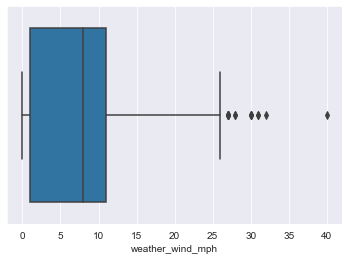

In [17]:
sns.boxplot(df.weather_wind_mph)

In [18]:
df[df['weather_wind_mph']>30]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium_neutral,weather_temperature,weather_wind_mph,total,over_under_result,stadium_name,stadium_location,stadium_open,stadium_type,stadium_capacity,stadium_surface,LATITUDE,LONGITUDE,zipcode,zipcode_away,dist_diff,weekday,home_W-L%,home_PD,home_MoV,home_SoS,home_SRS,home_OSRS,home_DSRS,home_PF_per_game,home_PA_per_game,away_W-L%,away_PD,away_MoV,away_SoS,away_SRS,away_OSRS,away_DSRS,away_PF_per_game,away_PA_per_game,home_superbowl_odds,away_superbowl_odds,diff_W-L%,diff_PD,diff_MoV,diff_SoS,diff_SRS,diff_OSRS,diff_PF_per_game,diff_PA_per_game,diff_superbowl_odds
3455,1994-12-24,1994,17,False,New York Giants,15.0,10.0,Dallas Cowboys,DAL,3.0,36.0,False,46.0,31.0,25,Under,Giants Stadium,"East Rutherford, NJ",1976,outdoor,80242,FieldTurf,40.6825,-74.1694,7073,75062,2210.873135,5,0.688,83.0,5.2,-0.5,4.6,-0.8,5.4,18.0000,12.8125,0.750,147.0,9.2,0.4,9.6,4.9,4.7,23.5000,14.3125,8000.0,300.0,0.062,64.0,4.0,0.9,5.0,5.7,5.5000,1.500,7700.0
6949,2008-12-28,2008,17,False,Buffalo Bills,0.0,13.0,New England Patriots,NE,5.5,34.5,False,51.0,32.0,13,Under,Ralph Wilson Stadium,"Orchard Park, NY",1973,outdoor,73967,FieldTurf,42.8890,-78.8901,14127,2035,617.481568,6,0.438,-102.0,-6.4,2.3,-4.1,-5.6,1.5,15.7500,22.1250,1.000,315.0,19.7,0.4,20.1,15.9,4.2,36.8125,17.1250,5000.0,350.0,0.562,417.0,26.1,1.9,24.2,21.5,21.0625,5.000,4650.0
7636,2011-11-13,2011,10,False,Cleveland Browns,12.0,13.0,St. Louis Rams,CLE,3.0,36.5,False,63.0,40.0,25,Under,FirstEnergy Stadium,"Cleveland, OH",1999,outdoor,68000,Grass,41.4057,-81.8520,44114,63102,792.000632,6,0.313,-61.0,-3.8,2.3,-1.5,-3.4,2.0,16.9375,20.7500,0.438,-39.0,-2.4,-4.2,-6.7,-6.3,-0.4,18.0625,20.5000,10000.0,5000.0,0.125,22.0,1.4,6.5,5.2,2.9,1.1250,0.250,5000.0
8196,2013-11-24,2013,12,False,Cleveland Browns,11.0,27.0,Pittsburgh Steelers,CLE,2.0,39.0,False,33.0,31.0,38,Under,FirstEnergy Stadium,"Cleveland, OH",1999,outdoor,68000,Grass,41.4057,-81.8520,44114,15212,181.765448,6,0.313,-66.0,-4.1,-1.2,-5.3,-4.6,-0.7,18.8750,23.0000,0.500,22.0,1.4,-2.0,-0.7,-2.8,2.1,21.0000,19.6250,10000.0,2200.0,0.187,88.0,5.5,0.8,4.6,1.8,2.1250,3.375,7800.0


In [19]:
wind_groups=[]
for i in df['weather_wind_mph']:
    if (i >= 0) & (i < 7):
        wind_groups.append(0)
    elif (i >= 7)&(i < 10):
        wind_groups.append(1)
    else:
        wind_groups.append(2)
df['Wind-Group'] = wind_groups

[Text(0, 0, 'Light'), Text(0, 0, 'Mild'), Text(0, 0, 'Heavy')]

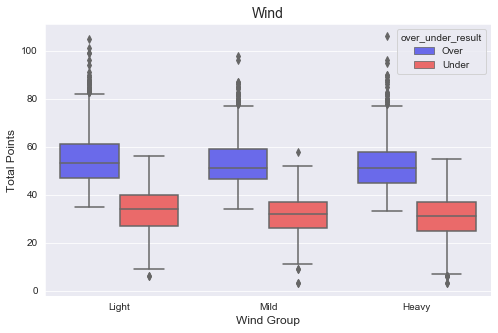

In [20]:
plt.subplots(figsize = (8,5));
mh = sns.boxplot(x = 'Wind-Group', y = 'total', hue = 'over_under_result',data = df, palette="seismic")
mh.set_title('Wind',fontsize=14)
mh.set_ylabel('Total Points',fontsize=12)
mh.set_xlabel('Wind Group',fontsize=12)
mh.set_xticklabels(['Light','Mild','Heavy'])

## Independant Variable 5: Stadium Capacity

In [21]:
df.stadium_capacity.describe()

count      9406.000000
mean      69070.465767
std        8743.523179
min       27000.000000
25%       64767.000000
50%       68756.000000
75%       76125.000000
max      100000.000000
Name: stadium_capacity, dtype: float64

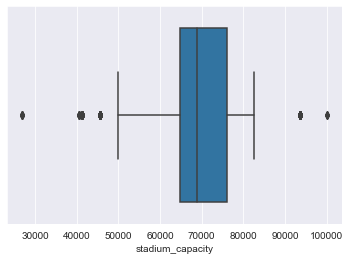

In [22]:
sns.boxplot(df.stadium_capacity)

Text(0.5, 0, 'Capacity')

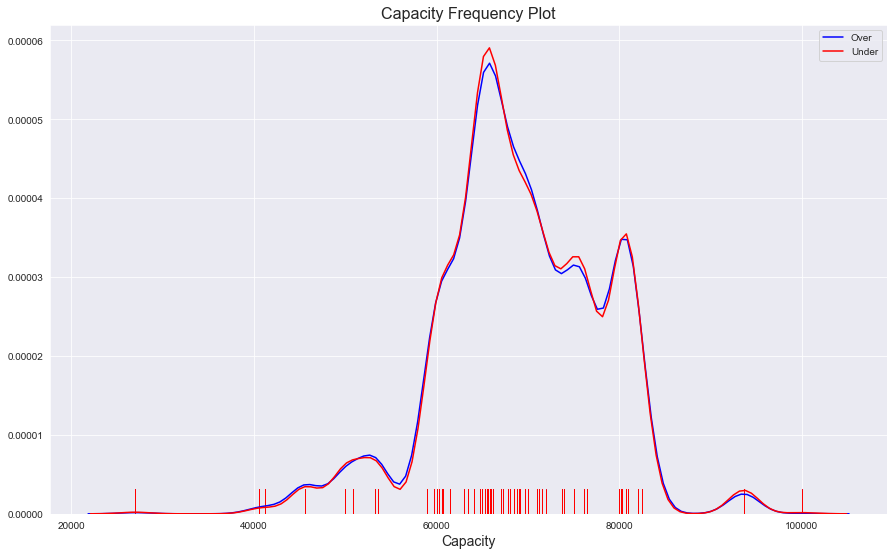

In [23]:
fig, ax = plt.subplots(figsize = (15,9));
op = sns.distplot(df[df['over_under_result']== 'Over'].stadium_capacity, color='blue',hist=False, rug=True, label = 'Over')
op = sns.distplot(df[df['over_under_result']== 'Under'].stadium_capacity, color='red',hist=False, rug=True, label = 'Under')
op.set_title('Capacity Frequency Plot',fontsize=16)
plt.xlabel('Capacity',fontsize=14)


# Independent Variable 7: Team Previous Season Data

In [25]:
df.columns

Index(['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph', 'total',
       'over_under_result', 'stadium_name', 'stadium_location', 'stadium_open',
       'stadium_type', 'stadium_capacity', 'stadium_surface', 'LATITUDE',
       'LONGITUDE', 'zipcode', 'zipcode_away', 'dist_diff', 'weekday',
       'home_W-L%', 'home_PD', 'home_MoV', 'home_SoS', 'home_SRS', 'home_OSRS',
       'home_DSRS', 'home_PF_per_game', 'home_PA_per_game', 'away_W-L%',
       'away_PD', 'away_MoV', 'away_SoS', 'away_SRS', 'away_OSRS', 'away_DSRS',
       'away_PF_per_game', 'away_PA_per_game', 'home_superbowl_odds',
       'away_superbowl_odds', 'diff_W-L%', 'diff_PD', 'diff_MoV', 'diff_SoS',
       'diff_SRS', 'diff_OSRS', 'diff_PF_per_game', 'diff_PA_per_game',
       'diff_superbowl_odds', 'Wind-Gr

In [51]:
season_data = df.drop(columns=['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'score_home', 'score_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph', 'total',
       'over_under_result', 'stadium_name', 'stadium_location', 'stadium_open',
       'stadium_type', 'stadium_capacity', 'stadium_surface', 'LATITUDE',
       'LONGITUDE', 'zipcode', 'zipcode_away', 'dist_diff', 'weekday','Wind-Group',
        'home_OSRS','home_MoV','home_PD','away_OSRS','away_MoV','away_PD',
        'away_DSRS','away_SRS','home_DSRS','home_SRS','diff_MoV','diff_SRS','diff_OSRS'] )

In [52]:
season_data

,team_home,team_away,home_W-L%,home_SoS,home_PF_per_game,home_PA_per_game,away_W-L%,away_SoS,away_PF_per_game,away_PA_per_game,home_superbowl_odds,away_superbowl_odds,diff_W-L%,diff_PD,diff_SoS,diff_PF_per_game,diff_PA_per_game,diff_superbowl_odds
0,Tampa Bay Buccaneers,Detroit Lions,0.313,-2.2,15.0625,16.1875,0.438,-1.2,18.1250,18.7500,25000.0,3500.0,0.125,8.0,1.0,3.0625,2.5625,21500.0
1,Buffalo Bills,Miami Dolphins,0.313,0.0,18.8750,22.1250,0.688,0.2,23.2500,15.8750,30000.0,900.0,0.375,170.0,0.2,4.3750,6.2500,29100.0
2,Chicago Bears,Green Bay Packers,0.438,-1.1,15.8125,17.1250,0.531,0.7,15.5625,16.8125,4000.0,10000.0,0.093,1.0,1.8,0.2500,0.3125,6000.0
3,Denver Broncos,Cincinnati Bengals,0.625,-0.2,17.6250,12.3750,0.250,0.7,15.7500,17.7500,1200.0,2500.0,0.375,116.0,0.9,1.8750,5.3750,1300.0
4,Kansas City Chiefs,Baltimore Colts,0.250,0.9,15.1875,20.4375,0.313,2.6,14.9375,26.3125,75000.0,3500.0,0.063,98.0,1.7,0.2500,5.8750,71500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9824,Detroit Lions,Green Bay Packers,0.375,-0.8,20.2500,22.5000,0.406,-1.2,23.5000,25.0000,8000.0,2000.0,0.031,12.0,0.4,3.2500,2.5000,6000.0
9825,Houston Texans,Tennessee Titans,0.688,-1.5,25.1250,19.7500,0.563,-0.2,19.3750,18.9375,5000.0,8000.0,0.125,79.0,1.3,5.7500,0.8125,3000.0
9829,Minnesota Vikings,Chicago Bears,0.531,-0.6,22.5000,21.3125,0.750,-2.3,26.3125,17.6875,2000.0,1200.0,0.219,119.0,1.7,3.8125,3.6250,800.0
9834,Houston Texans,Buffalo Bills,0.688,-1.5,25.1250,19.7500,0.375,-0.3,16.8125,23.3750,5000.0,10000.0,0.313,191.0,1.2,8.3125,3.6250,5000.0


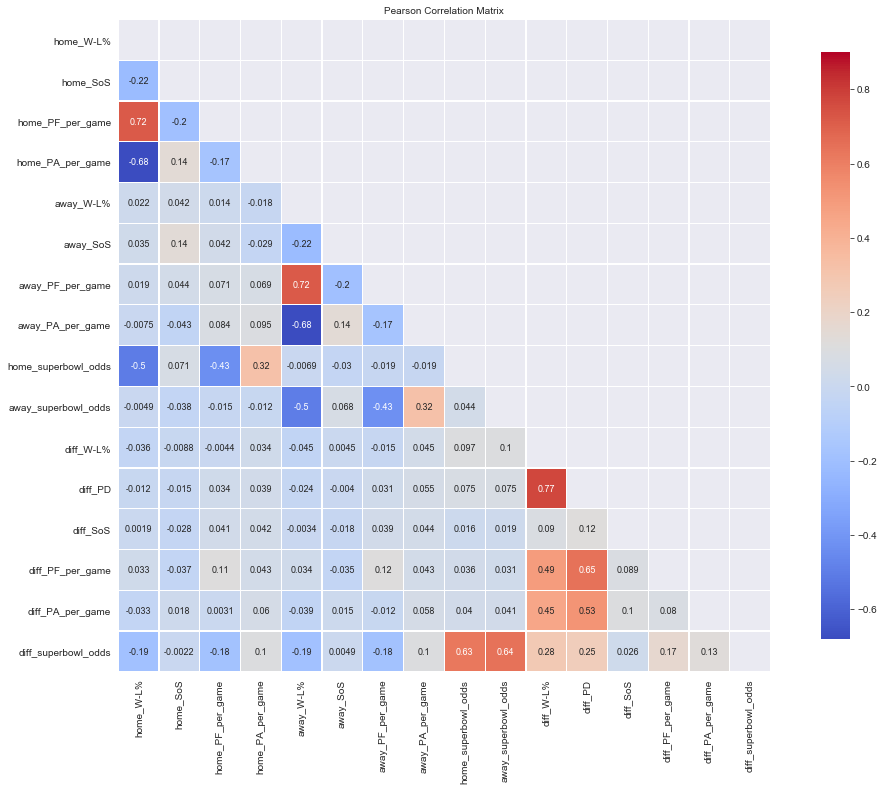

In [53]:
# Plot Correlation to Visualize Multi-Collinearity

mask = np.zeros_like(season_data.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 12))
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(season_data.corr(),linewidths=0.25,vmax=0.9,square=True,cmap="coolwarm",
            linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});
plt.show()